In [1]:
import numpy as np
import numpy.typing as npt
from numba import jit, njit, prange
import pickle
from dataclasses import dataclass, asdict, field
import argparse
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd
from pathlib import Path
from typing import Any
import time
import sys
import copy
import concurrent.futures as cf

from src.dataclass import (
    Input, Lattice, Parameter, Train, Save,
    Processed_Input, Topology, Conjugate, Result
)
from src.manage_data import save_result, save_log, load_result
from src.initial_state import get_initial_state
from src.process_input import (get_processed_input, get_T_and_H, get_J)
from src.metropolis import execute_metropolis_update
from src.function import (time_correlation, column_average_2d, get_spin_glass)
from src.process_output import get_result

In [2]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

"""
Memory
Max(measurement * size**dim, size**(2*dim)) * max_workers

Performance
measurement * size**dim * ensembles / max_workers
"""

"""
Lattice Condition
"""
args.size = 2**6
args.dimension = 2
args.ghost = 0
args.initial = "uniform" # "uniform", "random"

"""
Parameter Condition
"""
args.T, args.H = 1.0, 0.0
# q=2: 2.2692, q=3: 1.4925
# args.Tc = 1/((1-1/args.state)*np.log(1+np.sqrt(args.state)))
args.Tc = 1.5
args.Hc = 0.0
args.Jm = 1.0
args.Jv = 1.0

args.mode = "normal"  # 'normal', 'critical' and 'manual'
args.variable = "T"  # 'T', 'H'
args.multiply = 0.1**4
args.base = 2.0
args.exponent = 13

"""
Train Condition
"""
args.iteration = 2**10
args.measurement = 2**14
args.interval = 2**3
args.sweep = args.measurement * args.interval
args.ensemble = 2**3
args.max_workers = 2**3
args.threshold = 5 * 0.1**2
args.recent = 10**2

"""
Save Condition
"""
args.environment = "server" # "server" or "local"
args.save = True  # True or False

lattice = Lattice(
args.size, args.dimension, 
args.ghost, args.initial)
parameter = Parameter(
args.Tc, args.Hc, args.Jm, args.Jv, args.mode, 
args.variable, args.multiply, args.base, args.exponent)
train = Train(
args.iteration, args.sweep, args.measurement, args.interval,
args.ensemble, args.max_workers, args.threshold, args.recent)
save = Save(args.environment, args.save)

input = Input(lattice, parameter, train, save)
input.parameter.T, input.parameter.H = args.T, args.H

processed_input = get_processed_input(input)
input.parameter.T, input.parameter.H = get_T_and_H(input)
J = get_J(input, processed_input)
print(input)

TypeError: Save.__init__() missing 1 required positional argument: 'save'

In [ ]:
print(input)
update = get_initial_state(input)
iter = 1000
result = np.empty((iter+1, input.lattice.size**input.lattice.dimension), dtype=np.complex128)
result[0] = update
for i in range(iter):
    update = execute_metropolis_update(input, processed_input, J, update)
    result[i+1] = update
print(np.einsum("ij->i", result)/input.lattice.size**input.lattice.dimension)
print(np.einsum("ij->", result)/input.lattice.size**input.lattice.dimension/(iter+1))
%timeit execute_metropolis_update(input, processed_input, J, update)

In [ ]:
input.lattice.initial = "uniform"
input.parameter.Jv = 0.0
input.parameter.T = 1.5
# print(input)

processed_input = get_processed_input(input)
J = get_J(input, processed_input)
# print(J)

initial = get_initial_state(input)
print()
update = initial.copy()
for i in range(1000):
    update = execute_metropolis_update(input, processed_input, J, update)

measurement = 10000

raw_output = np.empty((measurement, args.size**args.dimension), dtype=np.complex128)
for j in range(measurement):
    update = execute_metropolis_update(input, processed_input, J, update)
    raw_output[j] = update

print(get_result(input, processed_input, raw_output, J))

In [ ]:
import numpy as np
import matplotlib as mpl
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation

In [ ]:
# xedges = [0, 1, 3, 5]
# yedges = [0, 2, 3, 4, 6]

size, dimension = 64, 2
measurement = 100

rng = np.random.default_rng()
data = np.exp(rng.random(size**dimension*measurement) * 2.0*np.pi*1j, dtype=np.complex128).reshape(measurement, size, -1)
data = np.angle(data)

H = data[0]
# H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
# H = H.T
print(H)

[[-1.90227856  0.61598335 -1.43753089 ...  0.04657852 -0.17751385
  -1.78554885]
 [ 2.62509005  2.1103718  -1.41462182 ...  2.64613323 -1.49280091
   2.17800923]
 [ 0.86522035  0.96828366 -0.50598393 ...  0.36758565  2.2799823
   1.5896178 ]
 ...
 [-0.56799321  2.60838472 -2.96188866 ...  1.45835997 -2.92065612
  -2.66316841]
 [-1.21902915 -0.91669361  0.10719229 ...  1.3046151   2.06359405
  -3.10389397]
 [ 1.19570487 -0.44773719 -0.19748035 ... -2.82339344 -1.16418043
  -0.64192591]]


In [ ]:
fig = plt.figure(figsize=(15, 7))

# ax = fig.add_subplot(131, title='imshow: square bins')
# im = ax.imshow(H, interpolation='nearest', origin='lower', cmap=cmap)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="10%", pad=0.05)

# plt.colorbar(im, cax=cax)

H = []

def animate(i):
    H.append(data[i])
    cmap = plt.cm.get_cmap('plasma')
    im = ax.imshow(H, interpolation='nearest', origin='lower', cmap=cmap)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)

    plt.colorbar(im, cax=cax)

ani = FuncAnimation(fig, animate, interval=measurement)

plt.show()

<Figure size 1500x700 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

# %matplotlib notebook

size, dimension = 64, 2
measurement = 100

rng = np.random.default_rng()
data = np.exp(rng.random(size**dimension*measurement)*2.0*np.pi*1j, dtype=np.complex128).reshape(measurement, size, -1)
data = np.angle(data)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots( figsize=(8,8) )
a = data[0]
cmap = plt.cm.get_cmap('hsv')
im = ax.imshow(a, interpolation='none', aspect='auto', vmin=-np.pi, vmax=np.pi, cmap=cmap)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

fps = 10
def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(data[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = measurement,
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

# plt.show()  # Not required, it seems!

<IPython.core.display.Javascript object>

...........Done!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

# %matplotlib notebook

size, dimension = 64, 2
measurement = 100

rng = np.random.default_rng()
data = np.exp(rng.random(size**dimension*measurement)*2.0*np.pi*1j, dtype=np.complex128).reshape(measurement, size, -1)
data = np.angle(data)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots( figsize=(8,8) )
a = data[0]
cmap = plt.cm.get_cmap('hsv')
im = ax.imshow(a, interpolation='none', aspect='auto', vmin=-np.pi, vmax=np.pi, cmap=cmap)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

fps = 10
def animate_func(i):
    im.set_array(data[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = measurement,
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

# plt.show()  # Not required, it seems!

1 2 3 4 5 6 7 8 9 10 Done!


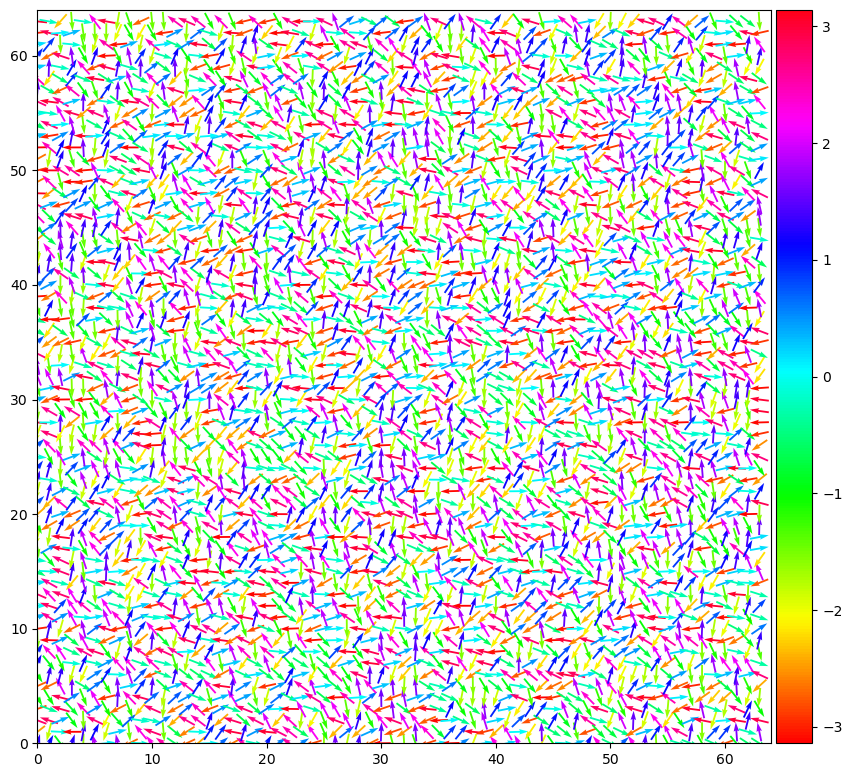

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

fps = 10
size, dimension = 64, 2
measurement = 100

rng = np.random.default_rng()
data = np.exp(rng.random(size**dimension*measurement)*2.0*np.pi*1j, dtype=np.complex128).reshape(measurement, size, -1)
data = np.angle(data)

x, y = np.mgrid[0 : size, 0 : size]

def get_arrow(i):
    u, v, M = np.cos(data[i]), np.sin(data[i]), data[i]
    
    return u, v, M

def update(i):
    if(i % fps == fps - 1):  print(int(i / fps) + 1, end=" ")
    global quiver
    quiver.remove()
    quiver = ax.quiver(x, y, *get_arrow(i), pivot='mid', width=0.0025*64/size, scale_units='x', scale=0.6, cmap=cmap)
    # ax.scatter(x,y, c='red', s=2.7)

fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.cm.get_cmap('hsv')
quiver = ax.quiver(x, y, *get_arrow(0), pivot='mid', width=0.0025*64/size, scale_units='x', scale=0.6, cmap=cmap)
ax.set_aspect('equal', adjustable='box')
# ax.scatter(x,y, c='red', s=2.7)
plt.xlim(0, size)
plt.ylim(0, size)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(quiver, cax=cax)

# ax.set_title(r'Vector field $\vec{F} = \sin x  \vec{i}+\cos y  \vec{j}$')

anim = animation.FuncAnimation(fig, update, frames = measurement, interval = 1000 / fps) # interval in ms

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
# anim.save('test_anim.mp4', fps=fps)

print('Done!')

In [ ]:
import matplotlib.pyplot as plt
cmap = plt.cm.get_cmap('hsv')

cmap(1)

(1.0, 0.02316178786767022, 0.0, 1.0)

In [ ]:
# fig = plt.figure(figsize=(7, 3))

# ax = fig.add_subplot(132, title='pcolormesh: actual edges',

#         aspect='equal')

# X, Y = np.meshgrid(xedges, yedges)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# cm = ax.pcolormesh(X, Y, H)
# plt.colorbar(cm, cax=cax)
# plt.show()